# Notebook 04 – Neural Network Model

In [35]:
import pandas as pd
import joblib
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from scikeras.wrappers import KerasClassifier
from sklearn.pipeline import Pipeline

Load data

In [36]:
# Load data
X_train = pd.read_csv("results/X_train_raw.csv")
y_train = pd.read_csv("results/y_train.csv")['Churn']
X_test = pd.read_csv("results/X_test_raw.csv")
y_test = pd.read_csv("results/y_test.csv")['Churn']


# Load preprocessor
preprocessor = joblib.load("results/preprocessor.pkl")

Define NN builder function

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


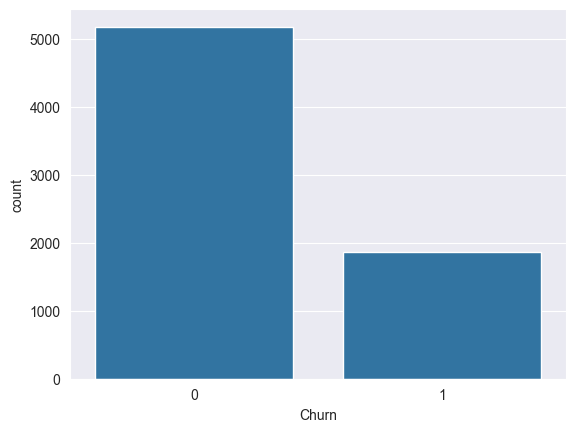

Resampled training set: [4139 4139]


In [ ]:
# Notebook 04 - Telco Customer Churn NN Model

# %%
# 1️⃣ Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

from imblearn.over_sampling import SMOTE
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

import warnings
warnings.filterwarnings("ignore")

# %%
# 2️⃣ Load dataset
data = pd.read_csv(r"C:\Users\USER\PycharmProjects\ML\data\Telco-Customer-Churn.csv")

# Drop customerID
data.drop(columns=['customerID'], inplace=True)

# Encode target
data['Churn'] = data['Churn'].map({'Yes': 1, 'No': 0})

# Convert TotalCharges to numeric
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')
data['TotalCharges'].fillna(data['TotalCharges'].median(), inplace=True)

# %%
# 3️⃣ Exploratory Data Analysis
print(data.info())
print(data.describe())
print(data['Churn'].value_counts())

# Visualize churn distribution
sns.countplot(x='Churn', data=data)
plt.show()

# %%
# 4️⃣ Preprocessing
categorical_cols = data.select_dtypes(include=['object']).columns.tolist()
numerical_cols = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_cols.remove('Churn')

# Column transformer
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_cols),
    ('cat', OneHotEncoder(drop='first'), categorical_cols)
])

# Split
X = data.drop('Churn', axis=1)
y = data['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# %%
# 5️⃣ Apply preprocessing
X_train_pre = preprocessor.fit_transform(X_train)
X_test_pre = preprocessor.transform(X_test)

# %%
# 6️⃣ Handle class imbalance using SMOTE
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train_pre, y_train)

print("Resampled training set:", np.bincount(y_train_res))

# %%
# 7️⃣ Build NN model
def create_nn(hidden_units=16, dropout_rate=0.2):
    model = Sequential()
    model.add(Dense(hidden_units, activation='relu', input_dim=X_train_res.shape[1]))
    model.add(Dropout(dropout_rate))
    model.add(Dense(hidden_units, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

keras_clf = KerasClassifier(model=create_nn, hidden_units=16, dropout_rate=0.2, epochs=50, batch_size=32, verbose=0)

# %%
# 8️⃣ Hyperparameter tuning
param_dist = {
    'hidden_units': [16, 32, 64],
    'dropout_rate': [0.1, 0.2, 0.3],
    'epochs': [30, 50],
    'batch_size': [16, 32]
}

rs_nn = RandomizedSearchCV(
    estimator=keras_clf,
    param_distributions=param_dist,
    n_iter=4,
    cv=3,
    scoring='accuracy',
    random_state=42
)

# Fit NN
rs_nn.fit(X_train_res, y_train_res)

print("Best NN parameters:", rs_nn.best_params_)
print("Best CV accuracy:", rs_nn.best_score_)

# %%
# 9️⃣ Evaluate on test set
y_pred = rs_nn.predict(X_test_pre)
acc = accuracy_score(y_test, y_pred)
print("Test Accuracy:", acc)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print(classification_report(y_test, y_pred))
